In [1]:
# Torch imports
import torch

import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn # Neural networks
import torch.optim as optiom # Optimizer, gradient descen adam, etc.

# Other Imports
import numpy as np 
import matplotlib.pyplot as plt


## Generating data with data generator class


In [2]:
# We define our domain as $[-1,1] x [0,4]$
xm = -2
xM = 2
t0 = 0 # t siempre empieza en cero
T1 = 4

number_of_points = 10000

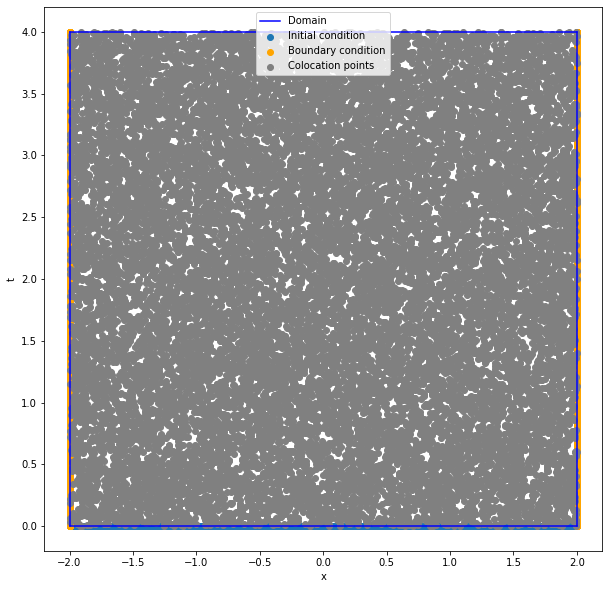

In [3]:
import pinn_data_generator as pdg

data_generator = pdg.dataGeneratorXT(xm, xM, t0, T1)

X_init_train, y_init_train = data_generator.generate_initial_condition_data(10000)
X_bc_train, y_bc_train = data_generator.generate_boundary_condition_data(10000)
X_coloc_train = data_generator.generate_collocation_points_data(20000)

data_generator.plot_data()

In [4]:
X_bc_train[-10:].shape, y_bc_train[-10:].shape

(torch.Size([10, 2]), torch.Size([10, 1]))

Text(0.5, 1.0, 'Initial condition')

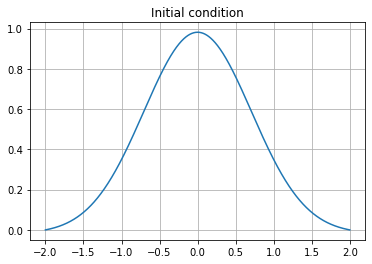

In [5]:
# plot of initial condition
plt.plot(X_init_train[:,0], y_init_train)
plt.grid()
plt.title("Initial condition")

## Instantiate Network

In [6]:
from pinn import PINN

layers = [2,64, 64, 1] #40,40,40,40,1]

fnn = PINN(layers)


# Optimizer
lr = 1e-3
optimizer = torch.optim.Adam(fnn.parameters(), lr = lr, )


In [7]:
%%time

torch.manual_seed(42)

epochs = 300
number_of_batches = 2

n_ic = len(X_init_train)
n_bc = len(X_bc_train) #Atencion. Esto lo estoy atando con alambras porque estoy uniendo toda al bc junto
n_coloc = len(X_coloc_train)

batch_size_ic = int(n_ic/number_of_batches)
batch_size_bc = int(n_bc/number_of_batches)
batch_size_coloc = int(n_coloc/number_of_batches)

epoch_number = []
epoch_loss = []


for ep in range(epochs):
    if ep%(epochs/10) == 0:
        print("entre")
    #Randomize the indexes to construct the batches
    indexes_ic = torch.randperm(n_ic)
    indexes_bc = torch.randperm(n_bc)
    indexes_coloc = torch.randperm(n_coloc)

    for k in range(number_of_batches):
        batch_index_ic = indexes_ic[k * batch_size_ic : (k+1)*batch_size_ic]
        batch_index_bc = indexes_bc[k * batch_size_bc : (k+1) * batch_size_bc]
        batch_index_coloc = indexes_coloc[k * batch_size_coloc : (k+1) * batch_size_coloc]

        # Entreno 
        # #ciclo clasico de pytorch.
        
        # Reset gradients to zero
        optimizer.zero_grad()

        # Prepare data
        X_init_batch = X_init_train[batch_index_ic]
        y_init_batch = y_init_train[batch_index_ic]

        X_bc_batch = X_bc_train[batch_index_bc]
        y_bc_batch = y_bc_train[batch_index_bc]        
        
        X_coloc_batch = X_coloc_train[batch_index_coloc]

        # Evaluate loss function on batch data
        loss = fnn.loss(X_ic = X_init_batch, 
                        y_ic = y_init_batch, 
                        X_bc = X_bc_batch, 
                        y_bc = y_bc_batch, 
                        X_coloc = X_coloc_batch,
                        lambda_ic = 1,
                        lambda_bc = 1,
                        lambda_coloc = 1)

        # Calculate gradients and update parameters.
        loss.backward()
        
        optimizer.step()

    #anoto la loss para graficar #onedb para logear
    if ep%(epochs/100) == 0:
        epoch_loss.append(loss)
        epoch_number.append(ep)
    if ep%(epochs/10) == 0:
        print(ep, loss)
        #entreno

entre
0 tensor(0.2910, grad_fn=<AddBackward0>)
entre
30 tensor(0.1161, grad_fn=<AddBackward0>)
entre
60 tensor(0.0566, grad_fn=<AddBackward0>)
entre
90 tensor(0.0377, grad_fn=<AddBackward0>)
entre
120 tensor(0.0319, grad_fn=<AddBackward0>)
entre
150 tensor(0.0305, grad_fn=<AddBackward0>)
entre
180 tensor(0.0302, grad_fn=<AddBackward0>)
entre
210 tensor(0.0305, grad_fn=<AddBackward0>)
entre
240 tensor(0.0306, grad_fn=<AddBackward0>)
entre
270 tensor(0.0295, grad_fn=<AddBackward0>)
CPU times: user 9min 56s, sys: 21min 41s, total: 31min 37s
Wall time: 5min 16s


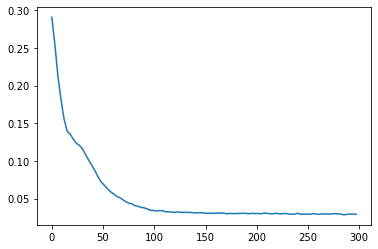

In [12]:
plt.plot(epoch_number,[el.detach().numpy() for el in epoch_loss])

In [13]:
x_plot = np.linspace(xm,xM,100)
t_plot = np.linspace(t0,T1,100)
x_plot, t_plot = np.meshgrid(x_plot, t_plot)

#Lo que necesito es una lista de listas Z que en la posicion Z[i,j] tenga el valor de la superficie en X[i][j] Y[i][j]

zv=[[1 for j in range(len(t_plot))] for i in range(len(x_plot)) ]

for i in range(len(x_plot)):
    for j in range(len(t_plot)):
        #print(np.array([xt[0][i][j],xt[1][i][j]]))
        aux = fnn(np.array( [x_plot[i][j], t_plot[i][j]] ))
        #zv[i][j] = aux.detach().numpy()[0]
        zv[i][j] = aux.detach().numpy()[0]
        #superficie(xt[0][i][j],xt[1][i][j])
print(t_plot.shape)
zv = np.array(zv, dtype = "float64")
zv.shape
#zv


(100, 100)


(100, 100)

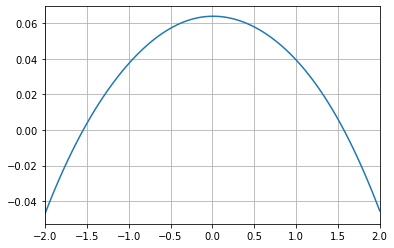

In [14]:
index = 90
fig, ax = plt.subplots()
ax.plot(np.linspace(xm,xM,len(zv[0])), zv[:][index])
ax.set_xlim([-2,2])
#plt.ylim= [0,0.5]
ax.grid()
plt.show()

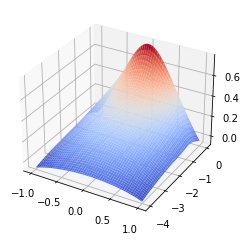

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

ax = plt.axes(projection="3d")

new_x = np.linspace(-1,1,100)
new_t = -1*np.linspace(0,4,100)
X,Y  = np.meshgrid(new_x, new_t)

ax.plot_surface(X, Y, zv, cmap="coolwarm")


plt.show()

In [19]:
estado = optimizer.state_dict()

In [28]:
estado["param_groups"]

[{'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'params': [0, 1, 2, 3, 4, 5]}]